In [318]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


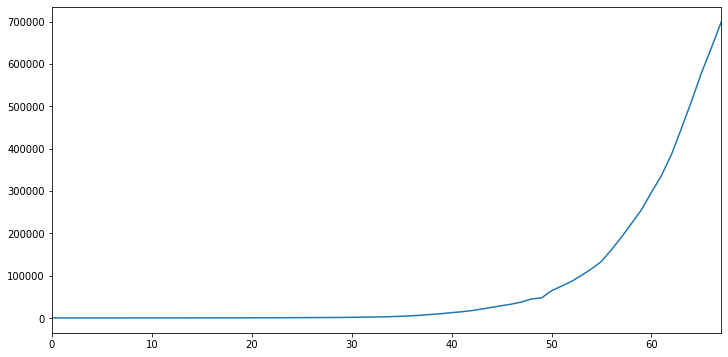

In [6]:
df['Confirmed'].plot(figsize=(12,6))

In [319]:
num_epochs = 100
batch_size = 32
split = 0.8
window = 18

In [320]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [321]:
training_set = df[:train_index]

In [322]:
# sc = MinMaxScaler(feature_range = (0, 1))
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set['Confirmed']).values))

In [323]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [324]:
print(X_train.shape, y_train.shape)

(36, 18, 1) (36,)


In [325]:
X_train[0]

array([[-2.07107464],
       [-1.78608801],
       [-1.65781972],
       [-1.46614432],
       [-1.39880767],
       [-1.25532316],
       [-1.19520496],
       [-1.12290229],
       [-0.99238881],
       [-0.92116155],
       [-0.89231617],
       [-0.87056068],
       [-0.82057041],
       [-0.79761199],
       [-0.77160173],
       [-0.63906186],
       [-0.60227767],
       [-0.58165805]])

In [326]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
54,2020-03-17,116044,55
55,2020-03-18,133719,56
56,2020-03-19,161344,57
57,2020-03-20,190785,58
58,2020-03-21,223091,59


In [327]:
real_conf = testing_set['Confirmed'].values

In [328]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [329]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [330]:
# inputs
# total

In [331]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [332]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(tf.keras.losses.MSLE(y_pred, y_true))

In [371]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 128, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 128))
# model.add(Dropout(0.2))

# model.add(Dense(units = 256))

model.add(Dense(units = 1, activation="relu"))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

In [372]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
cb = [checkpoint]

In [373]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 32 samples, validate on 4 samples
Epoch 1/100
32/32 [==============================] - 1s 21ms/step - loss: 0.3703 - val_loss: 0.8860
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3453 - val_loss: 0.6943
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3068 - val_loss: 0.5202
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2658 - val_loss: 0.3573
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2241 - val_loss: 0.1957
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1791 - val_loss: 0.0257
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1365 - val_loss: 0.1622
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1056 - val_loss: 0.2855
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1063 - val_loss: 0.2895
Epoch 10/100
32/32 [==============================] - 0s 3ms/step

Epoch 83/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0164
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0276
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0388
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0506
Epoch 87/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0556
Epoch 88/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0549
Epoch 89/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0468
Epoch 90/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0342
Epoch 91/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0257
Epoch 92/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0257


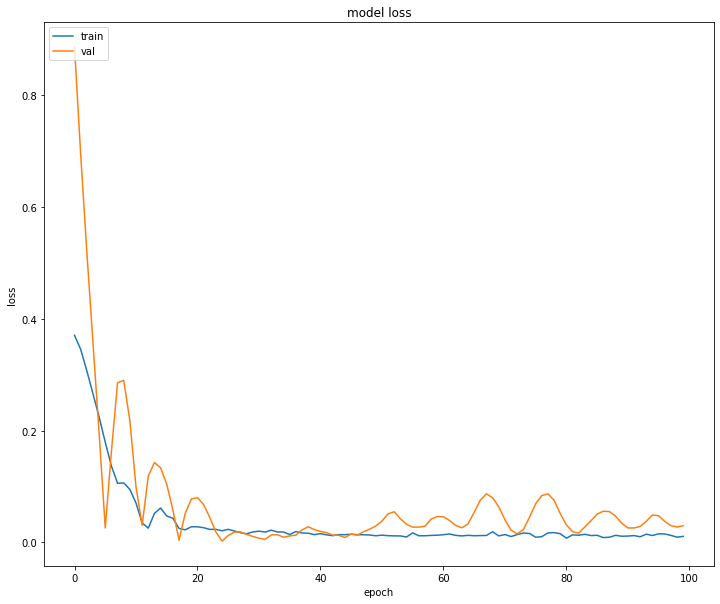

In [374]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [375]:
model.load_weights("model.h5")

In [376]:
predicted_conf = model.predict(X_test)

In [377]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.57259898],
       [0.67194317],
       [0.76565637],
       [0.83900455],
       [0.92200102],
       [0.98341353],
       [1.04657611],
       [1.12206572],
       [1.18793975],
       [1.24327849],
       [1.28922113],
       [1.34299932],
       [1.40890447],
       [1.42893952],
       [1.54237153],
       [1.60029679],
       [1.65215716],
       [1.70768343]])

In [378]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[121402.26],
       [142522.95],
       [166212.2 ],
       [192921.69],
       [223775.5 ],
       [259339.19],
       [299794.22],
       [345037.84],
       [394704.9 ],
       [448516.6 ],
       [507400.16],
       [572456.25],
       [643711.8 ],
       [719647.75]], dtype=float32)

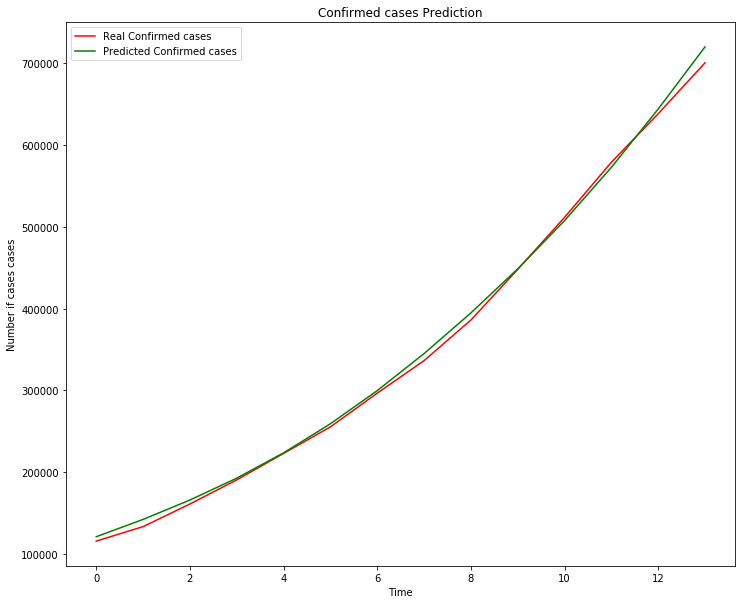

In [379]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()